In [29]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

In [7]:
data_df = pd.read_csv('data/Project-Data.csv')
data_df.head()

,Maturity,ZCYield,FuturesPrice
0,0.002778,0.014498,79.998782
1,0.020833,0.014426,79.994830
2,0.083333,0.014444,79.973349
3,0.166667,0.014399,79.954710
4,0.250000,0.014336,79.911934


In [8]:
sigma_r = 0.00023

maturities = data_df['Maturity'].values
zc_yields = data_df['ZCYield'].values
futures_prices = data_df['FuturesPrice'].values

## Q18) Bond pricing

$$
b_0(T, t, \lambda_r, \sigma_r, \bar{r}) = \frac{ e^{-2 \lambda_r (T-t)} \left( e^{\lambda_r (T-t)} - 1 \right) \left( \sigma_r^2 + e^{\lambda_r (T-t)} \left( 4 \lambda_r^2 \bar{r} - 3 \sigma_r^2 \right) \right) + 2 \lambda_r (T-t) \left( \sigma_r^2 - 2 \lambda_r^2 \bar{r} \right) }{ 4 \lambda_r^3 }
$$


In [11]:
def b0(T, t, lambda_r, sigma_r, r_bar):
    return (np.exp(-2 * lambda_r * (T-t)) * (np.exp(lambda_r * (T-t)) - 1) *
            (sigma_r**2 + np.exp(lambda_r * (T-t)) * (4 * lambda_r**2 * r_bar - 3 * sigma_r**2)) +
            2 * lambda_r * (T-t) * (sigma_r**2 - 2 * lambda_r**2 * r_bar)) / (4 * lambda_r**3)


$$
b_r(T, t, \lambda_r) = \frac{ e^{-\lambda_r (T-t)} - 1 }{ \lambda_r }
$$

In [ ]:
def br(T, t, lambda_r):
    return (np.exp(-lambda_r * (T-t)) - 1) / lambda_r

### Model Price Calculation:

$$
P_{\text{model}} = \exp \left( b_0(T, t, \lambda_r, \sigma_r, \bar{r}) + b_r(T, t, \lambda_r) \cdot r_0 \right)
$$

$$
P_{\text{market}} = \exp \left( -\text{yield} \cdot (T - t) \right)
$$


### Least Squares Calibration

In [13]:
def least_squares_objective(params):
    lambda_r, r_bar, r0 = params
    error = 0
    for maturity, yield_ in zip(maturities, zc_yields):
        T = maturity
        t = 0  # Assuming current time is 0
        P_model = np.exp(b0(T, t, lambda_r, sigma_r, r_bar) + br(T, t, lambda_r) * r0)
        P_market = np.exp(-yield_ * (T-t))
        error += (P_model - P_market) ** 2
    return error

initial_guess = [0.1, 0.03, 0.01]
least_squares_result = minimize(least_squares_objective, initial_guess, method='Nelder-Mead')
lambda_r_ls, r_bar_ls, r0_ls = least_squares_result.x
print(f'Least Squares Calibration:')
print(f'Mean reversion intensity (lambda_r): {lambda_r_ls}')
print(f'Long-term mean (r_bar): {r_bar_ls}')
print(f'Initial value (r0): {r0_ls}')

Least Squares Calibration:
Mean reversion intensity (lambda_r): 0.2991437388948194
Long-term mean (r_bar): 0.010033839633324947
Initial value (r0): 0.014603967286584005


### Maximum Likelihood Calibration

In [14]:
def log_likelihood(params):
    lambda_r, r_bar, r0 = params
    likelihood = 0
    for maturity, yield_ in zip(maturities, zc_yields):
        T = maturity
        t = 0  # Assuming current time is 0
        P_model = np.exp(b0(T, t, lambda_r, sigma_r, r_bar) + br(T, t, lambda_r) * r0)
        P_market = np.exp(-yield_ * (T-t))
        likelihood += norm.logpdf(P_market, loc=P_model, scale=sigma_r)
    return -likelihood  # Negative log-likelihood

mle_result = minimize(log_likelihood, initial_guess, method='Nelder-Mead')
lambda_r_mle, r_bar_mle, r0_mle = mle_result.x
print(f'Maximum Likelihood Calibration:')
print(f'Mean reversion intensity (lambda_r): {lambda_r_mle}')
print(f'Long-term mean (r_bar): {r_bar_mle}')
print(f'Initial value (r0): {r0_mle}')

Maximum Likelihood Calibration:
Mean reversion intensity (lambda_r): 0.2991437388948194
Long-term mean (r_bar): 0.010033839633324947
Initial value (r0): 0.014603967286584005


### Long Term Quantile Method

In [15]:
def quantile_objective(params):
    lambda_r, r_bar, r0 = params
    quantile_error = 0
    for maturity, yield_ in zip(maturities, zc_yields):
        T = maturity
        t = 0  # Assuming current time is 0
        P_model = np.exp(b0(T, t, lambda_r, sigma_r, r_bar) + br(T, t, lambda_r) * r0)
        P_market = np.exp(-yield_ * (T-t))
        quantile_error += np.abs(P_model - P_market)  # Absolute error for simplicity
    return quantile_error

# Perform the optimization
quantile_result = minimize(quantile_objective, initial_guess, method='Nelder-Mead')

# Extract the calibrated parameters
lambda_r_quantile, r_bar_quantile, r0_quantile = quantile_result.x

print(f'Long Term Quantile Calibration:')
print(f'Mean reversion intensity (lambda_r): {lambda_r_quantile}')
print(f'Long-term mean (r_bar): {r_bar_quantile}')
print(f'Initial value (r0): {r0_quantile}')

Long Term Quantile Calibration:
Mean reversion intensity (lambda_r): 0.16322924742036396
Long-term mean (r_bar): 0.008550775735612639
Initial value (r0): 0.01429913713437552


## Q19) Futures pricing

In [65]:
def calculate_volatility_and_correlation(matrix):
    # Extract variances from the diagonal of the matrix
    var_r = matrix[0, 0]  
    var_delta = matrix[1, 1] 
    var_log_O = matrix[2, 2] 
    
    # Calculate volatilities as the square roots of the variances
    sigma_r = np.sqrt(var_r)  
    sigma_delta = np.sqrt(var_delta) 
    sigma_O = np.sqrt(var_log_O) 
    
    # Extract covariances from the off-diagonal elements of the matrix
    cov_r_delta = matrix[0, 1]  
    cov_r_log_O = matrix[0, 2] 
    cov_delta_log_O = matrix[1, 2] 
    
    
    # Calculate correlations by dividing the covariances by the product of the respective volatilities
    rho_r_delta = cov_r_delta / (sigma_r * sigma_delta)  
    rho_r_log_O = cov_r_log_O / (sigma_r * sigma_O)  
    rho_delta_log_O = cov_delta_log_O / (sigma_delta * sigma_O) 
    
    return sigma_r, sigma_delta, sigma_O, rho_r_delta, rho_r_log_O, rho_delta_log_O

# Define the quadratic variation matrix
matrix = np.array([
    [0.000529, 0.00003312, 0.44712],  # First row: variance of r, covariance between r and delta, covariance between r and log(O)
    [0.00003312, 0.000144, 0.08352],  # Second row: covariance between delta and r, variance of delta, covariance between delta and log(O)
    [0.44712, 0.08352, 576]           # Third row: covariance between log(O) and r, covariance between log(O) and delta, variance of log(O)
]) * 1e-4 

# Calculate the volatilities and correlations
sigma_r, sigma_delta, sigma_O, rho_r_delta, rho_r_log_O, rho_delta_log_O = calculate_volatility_and_correlation(matrix)

# Print the calculated volatilities
print(f'Sigma_r: {sigma_r}')
print(f'Sigma_delta: {sigma_delta}')
print(f'Sigma_O: {sigma_O}')


Sigma_r: 0.00023
Sigma_delta: 0.00012
Sigma_O: 0.24000000000000002


### Futures Price Calculation

$$
f_{\text{price}}(t, T, r_t, \delta_t, O_t, \phi_0, \phi_r, \phi_\delta) = \exp \left( \phi_0 (T - t) + \phi_r (T - t) \cdot r_t + \phi_\delta (T - t) \cdot \delta_t \right) \cdot O_t
$$


In [66]:
def futures_price(t, T, rt, delta_t, Ot, phi_0, phi_r, phi_delta):
    exponent = phi_0 * (T - t) + phi_r * (T - t) * rt + phi_delta * (T - t) * delta_t        
    return np.exp(exponent) * Ot

$$ \phi_r(\tau, \lambda_r) = \frac{1 - \exp(-\lambda_r \cdot \tau)}{\lambda_r} $$


In [67]:
def phi_r(tau, lambda_r):
    return (1 - np.exp(-lambda_r * tau)) / lambda_r



$$ \phi_\delta(\tau, \lambda_\delta) = \frac{\exp(-\lambda_\delta \cdot \tau) - 1}{\lambda_\delta  }$$ 


In [68]:
def phi_delta(tau, lambda_delta):
    return (np.exp(-lambda_delta * tau) - 1) / lambda_delta



$$
\phi_0(\tau, \lambda_r, \lambda_\delta, \sigma_r, \sigma_\delta, \sigma_O, \bar{\delta}, \bar{r}) = \int_0^\tau \left[ \frac{1}{2} \left( \phi_\delta(s, \lambda_\delta) \left( 2 \lambda_\delta \bar{\delta} + \|\sigma_O\|^2 \phi_\delta(s, \lambda_\delta) + 2 \sigma_\delta^T \sigma_O \right) + 2 \phi_r(s, \lambda_r) \left( \lambda_r \bar{r} + \phi_\delta(s, \lambda_\delta) \sigma_r^T \sigma_O + \sigma_r^T \sigma_\delta \right) + \|\sigma_r\|^2 \phi_r^2(s, \lambda_r) \right) \right] ds
$$


In [69]:
def phi_0(tau, lambda_r, lambda_delta, sigma_r, sigma_delta, sigma_O, bar_delta, bar_r):
    def to_integrate(s):
        phi_delta_s = phi_delta(s, lambda_delta)
        phi_r_s = phi_r(s, lambda_r)
        term1 = phi_delta_s * (2 * lambda_delta * bar_delta + (np.linalg.norm(sigma_O) ** 2) * phi_delta_s + 2 * np.dot(sigma_delta.T, sigma_O))
        term2 = 2 * phi_r_s * (lambda_r * bar_r + phi_delta_s * np.dot(sigma_r.T, sigma_O) + np.dot(sigma_r.T, sigma_delta))
        term3 = (np.linalg.norm(sigma_r) ** 2) * (phi_r_s ** 2)
        return 0.5 * (term1 + term2 + term3)
    
    phi0, _ = integrate.quad(to_integrate, 0, tau)
    return phi0

In [74]:
def objective(params, futures_prices, maturities, r0, r_bar, lambda_r, sigma_r, sigma_delta,sigma_O, O0):
    lambda_delta, bar_delta, delta_0 = params
    t = 0
    r_t = r0 
    errors = []
    for T, f_observed in zip(maturities, futures_prices):
        phi_delta_ = phi_delta(T, lambda_delta)
        phi_r_ = phi_r(T, lambda_r)
        phi_0_ = phi_0(T, lambda_r, lambda_delta, sigma_r, sigma_delta, sigma_O, bar_delta, r_bar)
        f_theoretical = futures_price(t, T, r_t, delta_0, O0 , phi_0_, phi_r_, phi_delta_)
        # print(f'Theoretical Futures Price: {f_theoretical}')
        # print(f'Observed Futures Price: {f_observed}\n')
        error = f_observed - f_theoretical
        errors.append(error)
    # return np.sum(np.abs(errors)) # MAE
    return np.sum(np.square(errors)) # MSE

# Initial guesses for parameters
initial_guess = [0.3, 0.2, 0.001]
# Initial spot price of oil in dollars per barrel
init_spot_price_oil_pb = 80

# Minimize the objective function
args=(futures_prices, maturities, r0_mle, r_bar_mle, lambda_r_mle, sigma_r, sigma_delta, sigma_O, init_spot_price_oil_pb)
result = minimize(objective, initial_guess, args=args , method='Nelder-Mead')

# Extract the calibrated parameters
lambda_delta, bar_delta, delta_0 = result.x

print(f"Calibrated parameters:")
print(f"lambda_delta: {lambda_delta}")
print(f"bar_delta: {bar_delta}")
print(f"delta_0: {delta_0}")


Calibrated parameters:
lambda_delta: 1.3135751847235109
bar_delta: 0.02623297287115256
delta_0: 0.003952085934558563


## Q20) Storage options

$$
\psi_\delta(s) = \frac{1 - e^{-\lambda_\delta s}}{\lambda_\delta}

$$


In [ ]:
def psi_delta(tau):
    return (1 - np.exp(-lambda_delta * tau)) / lambda_delta


$$
\psi_0(s) = -\frac{1}{2} \|\sigma_\delta\|^2 \left( \frac{1 - e^{-\lambda_\delta s}}{\lambda_\delta} \right)^2 + \left( \lambda_\delta - \frac{1}{2} \|\sigma_\delta\|^2 \right) s - \frac{1 - e^{-\lambda_\delta s}}{\lambda_\delta}
$$


In [63]:
def psi_0(tau):
    return -0.5 * sigma_delta**2 * ((1 - np.exp(-lambda_delta * tau)) / lambda_delta)**2 \
           + (lambda_delta - 0.5 * sigma_delta**2) * tau \
            - (1 - np.exp(-lambda_delta * tau)) / lambda_delta


- We now compute :
$ H\left(\delta_{T_0}\right)=-\alpha \int_0^{\Delta} e^{\psi_0(\tau)+\psi_\delta(\tau) \delta_{T_0}} d \tau$

In [71]:
# Define the H function
def H(delta, alpha, Delta):
    to_integrate = lambda tau: np.exp(psi_0(tau) + psi_delta(tau) * delta)
    integral_value, _ = integrate.quad(to_integrate, 0, Delta)
    return -alpha * integral_value

The payoff at the start date is : 
$ H\left(\delta_{T_0}\right)^+ = max (0, H\left(\delta_{T_0}\right))$

In [75]:
# Compute the payoff at T0
def payoff_at_T0( delta_T0,alpha,Delta):
    # Compute H(delta_T0)
    H_value = H(delta_T0, alpha, Delta)
    # Compute the payoff at T0
    payoff_T0 = max(0, H_value)
    return payoff_T0

Now let's find the critical value of the convenience yield. We proved that $\delta^{+}$ satisfies $H(\delta^{+})=0 $


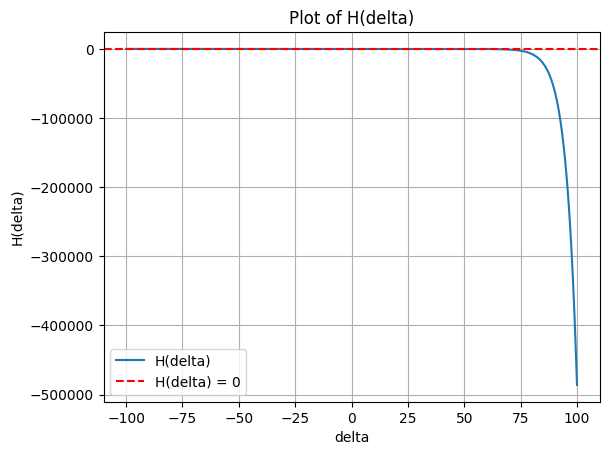

Critical Convenience Yield (delta*): None


In [64]:
bracket = [-100, 100] # We can adjust the bracket if brentq method
x0 = -1 # We can adjust the initial guess if newton method

def find_critical_delta(Delta, alpha):
    # result = root_scalar(H, args=(Delta, alpha), bracket=bracket, method='brentq')
    result = root_scalar(H, args=(Delta, alpha), x0=x0, method='newton')
    return result.root if result.converged else None

# Plot H(delta) for different values of delta
alpha = 0.01
Delta = 1/4
deltas = np.linspace(bracket[0], bracket[1], 1000)
H_values = [H(delta,Delta,alpha) for delta in deltas]

plt.plot(deltas, H_values, label='H(delta)')
plt.axhline(0, color='r', linestyle='--', label='H(delta) = 0')
plt.xlabel('delta')
plt.ylabel('H(delta)')
plt.title('Plot of H(delta)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate critical delta*
delta_star = find_critical_delta(Delta, alpha)
print(f"Critical Convenience Yield (delta*): {delta_star}")

Now we need to find the initial price of the storage option:
$$
\mathbb{E}_t^{\mathbb{Q}}\left[e^{-\int_t^{T_0} r_u d u} \mathcal{P}_{T_0}^{+}\right]=\mathcal{O}_t \mathbb{E}_t^{\overline{\mathbb{Q}}}\left[e^{-\int_t^{T_0} \delta_u d u} H\left(\delta_{T_0}\right)^{+}\right]
$$

So evaluating at $t=T_0$ gives : 

$$
\mathbb{E}_{T_0}^{\mathbb{Q}}\left[e^{-\int_{T_0}^{T_0} r_u d u} \mathcal{P}_{T_0}^{+}\right]=\mathcal{O}_{T_0} \mathbb{E}_{T_0}^{\overline{\mathbb{Q}}}\left[e^{-\int_{T_0}^{T_0} \delta_u d u} H\left(\delta_{T_0}\right)^{+}\right]
$$ 
which gives :
<!-- $$
\mathcal{P}_{T_0}^{+} = {O}_{T_0} H(\delta_{T_0})^{+}
$$ -->

$$ 
P_0 = {O}_{0} * e^{-\int_0^{T_0} r_u du } * H\left(\delta_{T_0}\right)^+
$$


In [79]:
# Define the function to compute the initial price of the storage option
def initial_price_of_storage_option(O_0, T0, Delta, alpha, delta_T0):
    # Compute the payoff at T0
    payoff_T0 = payoff_at_T0( delta_T0, Delta, alpha)

    # Define the discount factor integrand
    discount_integral = lambda tau: np.exp(-r * tau)
    
    # Compute the discount factor
    discount_factor, _ = integrate.quad(discount_integral, 0, T0)
    
    # Compute the initial price of the storage option
    initial_price = O_0* payoff_T0 * discount_factor
    return initial_price

## Q21) Sensitivity & Dependence 

In [77]:
def sensitivity_analysis(O_t, T0, Delta, delta_T0, lambda_delta, sigma_delta, r):
    
    alphas = np.linspace(0.05, 0.2, 10) # We vary the range of alpha
    prices_alpha = [initial_price_of_storage_option(O_t, T0, Delta, alpha, delta_T0, lambda_delta, sigma_delta, r) for alpha in alphas]
    
    T0s = np.linspace(0.1, 1, 10) # We vary the range of T0
    prices_T0 = [initial_price_of_storage_option(O_t, T, Delta, alpha, delta_T0, lambda_delta, sigma_delta, r) for T in T0s]
    
    Deltas = np.linspace(0.5, 2, 10) # We vary the range of Delta
    prices_Delta = [initial_price_of_storage_option(O_t, T0, D, alpha, delta_T0, lambda_delta, sigma_delta, r) for D in Deltas]
    
    rs = np.linspace(0.01, 0.1, 10) # We vary the range of r
    prices_r = [initial_price_of_storage_option(O_t, T0, Delta, alpha, delta_T0, lambda_delta, sigma_delta, rate) for rate in rs]
    
    # Plot the results
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(alphas, prices_alpha, label='Storage Cost (alpha)')
    plt.xlabel('alpha')
    plt.ylabel('Initial Price')
    plt.title('Sensitivity to alpha')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(T0s, prices_T0, label='Start Date (T0)')
    plt.xlabel('T0')
    plt.ylabel('Initial Price')
    plt.title('Sensitivity to T0')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(Deltas, prices_Delta, label='Storage Period (Delta)')
    plt.xlabel('Delta')
    plt.ylabel('Initial Price')
    plt.title('Sensitivity to Delta')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(rs, prices_r, label='Risk-Free Rate (r)')
    plt.xlabel('r')
    plt.ylabel('Initial Price')
    plt.title('Sensitivity to r')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Perform sensitivity analysis
T0 = 0.5
Delta = 1/4
alpha = 0.01
sensitivity_analysis(init_spot_price_oil_pb, T0, Delta, delta_T0, lambda_delta, sigma_delta, r)


NameError: name 'O_t' is not defined